# 03 - Regression Modeling

## 1. Import Packages <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np

import pprint as pp

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

## Table of Contents <a name="table"></a>
1. [Import Packages](#import)
2. [Transforming Data](#transform)
3. [Standardization](#scale)
4. [Feature Engineering](#feature)
5. [Cross-Validation](#val)
    1. [Regular](#reg)
    2. [LASSO](#lasso)
    3. [Ridge](#ridge)
5. [Results](#results)   

## 2. Transforming Data <a name="transform"></a>

"altmetric" should be log-transformed since it is non-negative and count-like<br>
"num_times_cited", "num_institutions", and "num_authors" could be log-transformed for better model performance.

In [3]:
#import the data
combined = pd.read_pickle('./data/combined_article_metrics.pkl') 
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,num_authors,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,9,1,1,2,10
1,8,6,112,59,5,8,42,5,1,1,5,10
2,10,24,551,62,5,7,38,33,0,1,9,10
3,9,33,647,51,7,10,52,14,0,1,12,10
4,7,1,473,57,5,10,49,6,1,1,2,10


In [4]:
#original model
df = combined.copy()
X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.13


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     21.48
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           2.77e-37
Time:                        13:54:52   Log-Likelihood:                -9261.9
No. Observations:                1266   AIC:                         1.855e+04
Df Residuals:                    1255   BIC:                         1.860e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              251.3673     46.189      5.442      0.000     160.750     341.984
title_length         6.6093      5.471      1.208      0.227      -4.125      17.344
num_times_cited      0.1441      0.026      5.559      0.000       0.093       0.195
abstract_length     -0.4140      0.302     -1.370      0.171      -1.007       0.179
page_length         -2.4681     13.284     -0.186      0.853     -28.530      23.594
fig_count           -4.8306      4.410     -1.095      0.274     -13.482       3.821
ref_cnt             -1.0856      0.598     -1.815      0.070      -2.259       0.088
num_authors          1.1146      0.466      2.392      0.017       0.201       2.029
top100              -3.7508     21.209     -0.177      0.860     -45.359      37.857
other              251.3673     46.189      5.442      0.000     160.750     341.984
num_institutions    -0.3923      0.789     -0.497      0.619      -1.940       1.156
year               -55.6676      4.183    -13.309      0.000     -63.874     -47.462
==============================================================================
Omnibus:                     1399.958   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99336.114
Skew:                           5.506   Prob(JB):                         0.00
Kurtosis:                      44.975   Cond. No.                     2.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.25e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The results improve from a log transform of the dependent variable. <br>
However, the test score is worse than the train score due to multi-collinearity.

In [5]:
#log model

df = combined.copy()
X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(np.log(y_train+1), X_train)

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit = model.fit() 
fit.summary()

/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


R^2 Score for Test: 0.13


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     125.0
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.64e-180
Time:                        13:54:58   Log-Likelihood:                -1880.9
No. Observations:                1266   AIC:                             3784.
Df Residuals:                    1255   BIC:                             3840.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.2333      0.136     23.830      0.000       2.967       3.500
title_length        -0.0119      0.016     -0.739      0.460      -0.043       0.020
num_times_cited      0.0010   7.62e-05     12.481      0.000       0.001       0.001
abstract_length     -0.0029      0.001     -3.291      0.001      -0.005      -0.001
page_length         -0.0149      0.039     -0.383      0.702      -0.091       0.062
fig_count           -0.0095      0.013     -0.737      0.461      -0.035       0.016
ref_cnt             -0.0025      0.002     -1.409      0.159      -0.006       0.001
num_authors          0.0075      0.001      5.515      0.000       0.005       0.010
top100               0.1546      0.062      2.482      0.013       0.032       0.277
other                3.2333      0.136     23.830      0.000       2.967       3.500
num_institutions    -0.0050      0.002     -2.173      0.030      -0.010      -0.000
year                -0.3916      0.012    -31.868      0.000      -0.416      -0.367
==============================================================================
Omnibus:                        7.630   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.796
Skew:                           0.155   Prob(JB):                       0.0203
Kurtosis:                       3.228   Cond. No.                     2.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.25e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The results further improved from taking the log transform of 'num_times_cited', 'num_institutions', and 'num_authors'.

In [6]:
#log model with scaled and log-transformed independent variables

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

X, y = df.drop(columns = ['altmetric']), df['altmetric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train = sm.add_constant(X_train, has_constant='add') #something already has a variance of 0
model = sm.OLS(y_train, X_train)


fit = model.fit() 

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.53


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     164.2
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          6.61e-220
Time:                        13:55:01   Log-Likelihood:                -1788.9
No. Observations:                1266   AIC:                             3600.
Df Residuals:                    1255   BIC:                             3656.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9018      0.133     14.332      0.000       1.642       2.162
title_length        -0.0062      0.015     -0.413      0.680      -0.036       0.023
num_times_cited      0.5800      0.035     16.694      0.000       0.512       0.648
abstract_length      0.0008      0.001      0.888      0.375      -0.001       0.002
page_length         -0.0112      0.035     -0.325      0.745      -0.079       0.057
fig_count            0.0029      0.012      0.243      0.808      -0.021       0.027
ref_cnt             -0.0052      0.002     -3.158      0.002      -0.008      -0.002
num_authors          0.0911      0.038      2.408      0.016       0.017       0.165
top100               0.0397      0.061      0.651      0.515      -0.080       0.159
other                1.9018      0.133     14.332      0.000       1.642       2.162
num_institutions     0.1326      0.041      3.199      0.001       0.051       0.214
year                -0.4780      0.014    -33.767      0.000      -0.506      -0.450
==============================================================================
Omnibus:                       19.130   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.220
Skew:                           0.246   Prob(JB):                     2.47e-05
Kurtosis:                       3.400   Cond. No.                     1.95e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Return to [Table of Contents](#table)

## 3. Standardization <a name="scale"></a>

We will only scale the non-categorical independent variables and combine it back with our categorical data.

In [7]:
#log model with scaled and log-transformed independent variables

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])
        
X, y = df.drop(columns = ['altmetric']), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)


#scale only the non-categorical columns
cat_cols = ['top100', 'other']
scaled_cols = X_train.columns[~X_train.columns.isin(cat_cols)]

scaler = StandardScaler()

#drop the columns to be scaled to make reassigning easier
X_train, scaled_train_cols = X_train.drop(columns = scaled_cols), \
                                scaler.fit_transform(X_train[scaled_cols])

X_test, scaled_test_cols = X_test.drop(columns = scaled_cols), \
                                scaler.transform(X_test[scaled_cols])

#recreate the columns with the scaled values
#while making sure to reassign at the correct index
X_train[scaled_cols] = pd.DataFrame(scaled_train_cols,
                                    index = X_train.index,
                                    columns = scaled_cols)

X_test[scaled_cols] = pd.DataFrame(scaled_test_cols,
                                   index = X_test.index,
                                   columns = scaled_cols)


#something already has a variance of 0
X_train = sm.add_constant(X_train, has_constant='add') 

model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.53


/home/kchiv/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     164.2
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          6.61e-220
Time:                        13:55:03   Log-Likelihood:                -1788.9
No. Observations:                1266   AIC:                             3600.
Df Residuals:                    1255   BIC:                             3656.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.1778      0.020    109.215      0.000       2.139       2.217
top100               0.0397      0.061      0.651      0.515      -0.080       0.159
other                2.1778      0.020    109.215      0.000       2.139       2.217
title_length        -0.0117      0.028     -0.413      0.680      -0.067       0.044
num_times_cited      0.7255      0.043     16.694      0.000       0.640       0.811
abstract_length      0.0312      0.035      0.888      0.375      -0.038       0.100
page_length         -0.0101      0.031     -0.325      0.745      -0.071       0.051
fig_count            0.0082      0.034      0.243      0.808      -0.058       0.075
ref_cnt             -0.0928      0.029     -3.158      0.002      -0.150      -0.035
num_authors          0.0927      0.038      2.408      0.016       0.017       0.168
num_institutions     0.1384      0.043      3.199      0.001       0.054       0.223
year                -1.3636      0.040    -33.767      0.000      -1.443      -1.284
==============================================================================
Omnibus:                       19.130   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.220
Skew:                           0.246   Prob(JB):                     2.47e-05
Kurtosis:                       3.400   Cond. No.                     5.52e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.46e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [8]:
X_train.columns[~X_train.columns.isin(scaled_cols)]

Index(['const', 'top100', 'other'], dtype='object')

As it turns out, "top100" had multi-collinearity with the intercept due it having 0 variance. <br>
Removing that fixed the issues. <br>
Features with low statistical significance i.e. high p-values were also removed.

In [9]:
#log model with fewer scaled and log-transformed independent variables

df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

#scale data
scaler = StandardScaler()

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#something already has a variance of 0
X_train = sm.add_constant(X_train, has_constant='add') 

model = sm.OLS(y_train, X_train)

fit = model.fit()

X_test = sm.add_constant(X_test, has_constant='add') 
y_pred = fit.predict(X_test)
print('R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

fit.summary()

R^2 Score for Test: 0.53


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     328.8
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          1.71e-225
Time:                        13:55:27   Log-Likelihood:                -1789.9
No. Observations:                1266   AIC:                             3592.
Df Residuals:                    1260   BIC:                             3623.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3740      0.028    156.060      0.000       4.319       4.429
x1             0.7059      0.040     17.785      0.000       0.628       0.784
x2            -0.0944      0.029     -3.259      0.001      -0.151      -0.038
x3             0.0907      0.038      2.384      0.017       0.016       0.165
x4             0.1501      0.040      3.795      0.000       0.073       0.228
x5            -1.3621      0.040    -34.135      0.000      -1.440      -1.284
==============================================================================
Omnibus:                       17.981   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.666
Skew:                           0.242   Prob(JB):                     5.37e-05
Kurtosis:                       3.373   Cond. No.                         2.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Return to [Table of Contents](#table)

## 4. Feature Engineering <a name="feature"></a>

Here we try some feature engineering as well with PolynomialFeatures. <br>
The results offer a modest improvement, but not enough to justify its use.

In [10]:
df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)


#scale data and generate new features
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_train = poly.fit_transform(X_train)

X_test = scaler.transform(X_test)
X_test = poly.transform(X_test)

#something already has a variance of 0
X_train = sm.add_constant(X_train, has_constant='add') 


model = sm.OLS(y_train, X_train)

fit = model.fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     87.20
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          5.59e-220
Time:                        13:55:30   Log-Likelihood:                -1764.1
No. Observations:                1266   AIC:                             3570.
Df Residuals:                    1245   BIC:                             3678.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1837      0.025     87.218      0.000       2.135       2.233
x1             2.1837      0.025     87.218      0.000       2.135       2.233
x2             0.7218      0.045     15.907      0.000       0.633       0.811
x3            -0.1889      0.040     -4.771      0.000      -0.267      -0.111
x4             0.0570      0.055      1.029      0.303      -0.052       0.166
x5             0.1699      0.055      3.067      0.002       0.061       0.279
x6            -1.3532      0.045    -30.388      0.000      -1.441      -1.266
x7             0.0873      0.036      2.393      0.017       0.016       0.159
x8             0.1192      0.050      2.393      0.017       0.021       0.217
x9             0.0903      0.057      1.581      0.114      -0.022       0.202
x10           -0.1799      0.055     -3.248      0.001      -0.289      -0.071
x11            0.0230      0.067      0.341      0.733      -0.109       0.155
x12           -0.0009      0.005     -0.158      0.875      -0.012       0.010
x13           -0.0319      0.048     -0.667      0.505      -0.126       0.062
x14            0.0255      0.046      0.556      0.578      -0.064       0.115
x15           -0.1983      0.056     -3.550      0.000      -0.308      -0.089
x16            0.0567      0.039      1.446      0.148      -0.020       0.134
x17           -0.0488      0.040     -1.213      0.225      -0.128       0.030
x18           -0.0946      0.060     -1.583      0.114      -0.212       0.023
x19           -0.0045      0.039     -0.115      0.908      -0.080       0.072
x20            0.1310      0.059      2.203      0.028       0.014       0.248
x21           -0.1178      0.047     -2.512      0.012      -0.210      -0.026
==============================================================================
Omnibus:                       12.831   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.055
Skew:                           0.190   Prob(JB):                     0.000887
Kurtosis:                       3.350   Cond. No.                     1.29e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.5e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Return to [Table of Contents](#table)

## 5. Cross-Validation <a name="val"></a>

In [11]:
df = combined.copy()
log_cols = ['altmetric', 'num_times_cited', 'num_institutions', 'num_authors']

for col in log_cols:
    if col == 'altmetric':
        df[col] = np.log(df[col] + 1)
    else:
        df[col] = np.log(df[col])

drop_cols = ['altmetric','other', 'top100', 'title_length', 
             'abstract_length','page_length', 'fig_count']        
        
X, y = df.drop(columns = drop_cols), df['altmetric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

#scale data
scaler = StandardScaler()

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5A. Regular  <a name="reg"></a>

In [12]:
lm = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

scores = cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')

print('R^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
print('\nR^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

R^2 Scores Across Folds:
[0.53749217 0.61061453 0.53484424 0.61640161 0.5053464 ]

Simple Mean CV R^2: 0.561 +- 0.044

R^2 Score for Test: 0.53


### 5B. LASSO  <a name="lasso"></a>

In [16]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

#This is the best alpha value it found - not far from the value
#selected using simple validation
print('Best alpha value for LASSO: ' + str(lasso_model.alpha_))

#These are the (standardized) coefficients found
#when it refit using that best alpha
print('\nBeta Coefficients for LASSO:')
pp.pprint(list(zip(X.columns, lasso_model.coef_)))

lasso_model = Lasso(alpha = 0.01)

scores = cross_val_score(lasso_model, X_train, y_train, cv=kf, scoring='r2')

print('\nR^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

lasso_model.fit(X_train, y_train)

#Make predictions on the test set using the new model
y_pred = lasso_model.predict(X_test)
print('\nLASSO R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))

Best alpha value for LASSO: 0.01

Beta Coefficients for LASSO:
[('num_times_cited', 0.6776115674476927),
 ('ref_cnt', -0.0793647647705093),
 ('num_authors', 0.08623889484343929),
 ('num_institutions', 0.1523097073200145),
 ('year', -1.3309224723401527)]

R^2 Scores Across Folds:
[0.53828039 0.60880223 0.53307737 0.61682156 0.50711864]

Simple Mean CV R^2: 0.561 +- 0.044

LASSO R^2 Score for Test: 0.53


### 5C. Ridge  <a name="ridge"></a>

In [17]:
#Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

#This is the best alpha value it found - not far from the value
#selected using simple validation
print('\nBest alpha value for Ridge: ' + str(ridge_model.alpha_))

#These are the (standardized) coefficients found
#when it refit using that best alpha
print('\nBeta Coefficients for Ridge:')
pp.pprint(list(zip(X.columns, ridge_model.coef_)))

ridge_model = Ridge(alpha = 5.14587)

scores = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring='r2')

print('\nR^2 Scores Across Folds:')
print(scores)
print(f'\nSimple Mean CV R^2: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

ridge_model.fit(X_train, y_train)


#Make predictions on the test set using the new model
y_pred = ridge_model.predict(X_test)
print('\nRidge R^2 Score for Test: ' + str(round(r2_score(y_test, y_pred), 2)))


Best alpha value for Ridge: 5.415871378079471

Beta Coefficients for Ridge:
[('num_times_cited', 0.6923908603009206),
 ('ref_cnt', -0.09191536316201651),
 ('num_authors', 0.09188107559845608),
 ('num_institutions', 0.15353755321840368),
 ('year', -1.346590455614971)]

R^2 Scores Across Folds:
[0.53725617 0.60997323 0.53425082 0.61702043 0.50618867]

Simple Mean CV R^2: 0.561 +- 0.044

Ridge R^2 Score for Test: 0.53


In the end, OLS still does as well as LASSO and Ridge as seen by the plot. <br>
There are no circles outside each box plot, indicating no outliers. <br>
It is time to interpret the beta-coefficients.

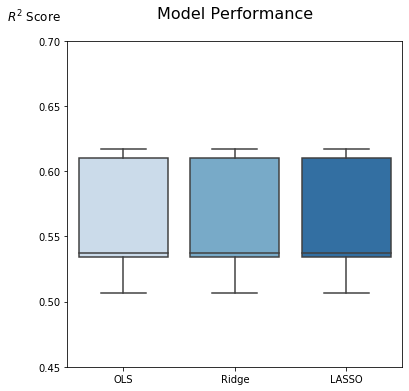

In [119]:
models = {'OLS':  LinearRegression(),
          'Ridge': Ridge(alpha = 5.14587),
          'LASSO': Lasso(alpha = 0.01)}

scores_df = pd.DataFrame(columns = ['Model', 'Fold', 'Score'])

for model_idx, (model_name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(ridge_model, X_train, y_train, 
                                 cv=kf, scoring='r2')
    for score_idx, score in enumerate(scores):
        idx = model_idx*len(scores) + score_idx
        scores_df.loc[idx] = [model_name, score_idx, score]

plt.figure(figsize=(6,6));
sns.boxplot(x='Model', y='Score', data=scores_df, palette='Blues')
plt.ylim([0.5, 0.6]);
plt.yticks(np.arange(0.45, 0.75, 0.05));
plt.ylabel('$R^{2}$ Score', rotation = 0, fontsize = 12, y = 1.05);
plt.xlabel(None);
plt.title('Model Performance',fontsize = 16, y = 1.05);

Return to [Table of Contents](#table)

## 6. Results <a name="results"></a>

To interpret the beta coefficients, we first exponential transform the standard deviations of independent variables that were log transformed. <br> 
We then divide each feature's beta coefficient value by each feature's original standard deviation. <br>
Next, we must exponential transform our beta coefficients since we applied a log transform to the dependent variable. <br>

The results indicate that: <br>
- for every additional time an article is cited, an article increases its Altmetric score by 1.22 <br>
- for every additional institution involved, an article increases its Altmetric score by 1.05 <br>
- for every additional author that worked on the paper, an article increases its Altmetric score by 1.03 <br>
- for every additional reference used, an article increases its Altmetric score by 0.99 <br>
- for every additional year since publication, an article increases its Altmetric score by 0.62 <br>

The Altmetric score uses the number of citiations as a factor, so its helpful to note that it is the most important factor <br>
Obviously, some recommendations are more feasible than others. <br>
Using additional references and involving more people is one way to increase article impact, but it may minimize impact from personal contributions.

In [64]:
log_cols = ['num_times_cited', 'num_institutions', 'num_authors']

scales = list(zip(X.columns, scaler.scale_))
scales = [np.exp(scale[1]) if scale[0] in log_cols else scale[1] for scale in scales]

coefs = list(zip(X.columns, np.exp(lm.coef_/scales)))
coefs = sorted(coefs, key=lambda x:x[1], reverse = True)
coefs

[('num_times_cited', 1.2239503499027489),
 ('num_institutions', 1.054275226855992),
 ('num_authors', 1.033348636285743),
 ('ref_cnt', 0.9947693533855977),
 ('year', 0.620330061464877)]

Return to [Table of Contents](#table)